In [2]:
from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt


from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.utils import shuffle


useTFIDF = True
showSampleVector = False
showMostInformativeFeatures = True
howManyInformativeFeatures = 20
nGRAM1 = 8
nGRAM2 = 10
weight = 4

ask = input("Do you want to specify parameters or use default values? Input 'T' or 'F'.   ")
if ask == "T":
    useTFIDFStr = input("Do you want to use tfidfVectorizer or CountVectorizer? Type T for tfidfVectorizer and F for CountVectorizer   ")
    if useTFIDFStr == "T":
        useTFIDF = True
    else:
        useTFIDF = False

    showSampleVectorStr = input("Do you want to print an example vectorized corpus? (T/F)   ")
    if showSampleVectorStr == "T":
        showSampleVector = True
    else:
        showSampleVector = False

    showMostInformativeFeaturesStr = input("Do you want to print the most informative feature in some of the classifiers? (T/F)   ")
    if showMostInformativeFeaturesStr == "T":
        showMostInformativeFeatures = True
        howManyInformativeFeatures = int(input("How many of these informative features do you want to print for each binary case? Input a number   "))
    else:
        showMostInformativeFeatures = False

    nGRAM1 = int(input("N-Gram lower bound (Read README.md for more information)? Input a number   "))
    nGRAM2 = int(input("N-Gram Upper bound? Input a number   "))
    weight = int(input("What weight do you want to use to separate train & testing? Input a number   "))


main_corpus = []
main_corpus_target = []

my_categories = ['benign', 'malware']

# feeding corpus the testing data

print("Loading system call database for categories:")
print(my_categories if my_categories else "all")


import glob
import os

malCOUNT = 0
benCOUNT = 0
for filename in glob.glob(os.path.join('./sysMAL', '*.txt')):
    fMAL = open(filename, "r")
    aggregate = ""
    for line in fMAL:
        linea = line[:(len(line)-1)]
        aggregate += " " + linea
    main_corpus.append(aggregate)
    main_corpus_target.append(1)
    malCOUNT += 1

for filename in glob.glob(os.path.join('./sysBEN', '*.txt')):
    fBEN = open(filename, "r")
    aggregate = ""
    for line in fBEN:
        linea = line[:(len(line) - 1)]
        aggregate += " " + linea
    main_corpus.append(aggregate)
    main_corpus_target.append(0)
    benCOUNT += 1

# shuffling the dataset
main_corpus_target, main_corpus = shuffle(main_corpus_target, main_corpus, random_state=3)


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


# weight as determined in the top of the code
train_corpus = main_corpus[:(weight*len(main_corpus)//(weight+1))]
train_corpus_target = main_corpus_target[:(weight*len(main_corpus)//(weight+1))]
test_corpus = main_corpus[(len(main_corpus)-(len(main_corpus)//(weight+1))):]
test_corpus_target = main_corpus_target[(len(main_corpus)-len(main_corpus)//(weight+1)):]




# size of datasets
train_corpus_size_mb = size_mb(train_corpus)
test_corpus_size_mb = size_mb(test_corpus)


print("%d documents - %0.3fMB (training set)" % (
    len(train_corpus_target), train_corpus_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(test_corpus_target), test_corpus_size_mb))
print("%d categories" % len(my_categories))
print()
print("Benign Traces: "+str(benCOUNT)+" traces")
print("Malicious Traces: "+str(malCOUNT)+" traces")
print()



print("Extracting features from the training data using a sparse vectorizer...")
t0 = time()

if useTFIDF:
    vectorizer = TfidfVectorizer(ngram_range=(nGRAM1, nGRAM2), min_df=1, use_idf=True, smooth_idf=True) ##############
else:
    vectorizer = CountVectorizer(ngram_range=(nGRAM1, nGRAM2))

analyze = vectorizer.build_analyzer()


X_train = vectorizer.fit_transform(train_corpus)

if showSampleVector:
    print(vectorizer.get_feature_names())
    print(X_train.toarray()[0])


duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, train_corpus_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer...")
t0 = time()
X_test = vectorizer.transform(test_corpus)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, test_corpus_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()


# show which are the definitive features
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    coefs_with_fns_mal = coefs_with_fns[:-(n + 1):-1]
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))[:n]

    print()
    print("Most Informative Benign Features:")
    for (coef_1, fn_1) in coefs_with_fns:
        print(coef_1, fn_1)
    print()
    print("Most Informative Malicious Features:")
    for (coef_2, fn_2) in coefs_with_fns_mal:
        print(coef_2, fn_2)
    print()



test_corpus_target = np.array(test_corpus_target)



Do you want to specify parameters or use default values? Input 'T' or 'F'.   F
Loading system call database for categories:
['benign', 'malware']
177 documents - 45.876MB (training set)
44 documents - 13.033MB (test set)
2 categories

Benign Traces: 72 traces
Malicious Traces: 150 traces

Extracting features from the training data using a sparse vectorizer...
done in 12.276854s at 3.737MB/s
n_samples: 177, n_features: 601747

Extracting features from the test data using the same vectorizer...
done in 2.911314s at 4.477MB/s
n_samples: 44, n_features: 601747



In [18]:
   
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=0)
print('_'*60)
print("Training: ")
print(classifier)
probas_ = classifier.fit(X_train, train_corpus_target).predict_proba(X_test)

# print("shape test_corpus_target: ", np.shape(test_corpus_target))
# print("shape probas: ", np.shape(probas_[:, 0]))

pred = classifier.predict(X_test)

score = metrics.accuracy_score(test_corpus_target, pred)

print(score)

____________________________________________________________
Training: 
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)
0.863636363636


test_corpus_target: [0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1
 1 1 0 0 1 0 1]
probas:  [ 0.05474941  0.97921566  0.95257291  0.97773203  0.80141375  0.93786412
  0.95801548  0.3235057   0.06153557  0.06118044  0.96354314  0.97019558
  0.98409898  0.94734594  0.9368117   0.57898114  0.78624253  0.95391293
  0.60324848  0.94932021  0.96299873  0.07860315  0.95579399  0.95986754
  0.731816    0.05519597  0.96316162  0.07510261  0.9526102   0.12094996
  0.29382029  0.98571718  0.70542942  0.61345102  0.98660129  0.08115918
  0.96705875  0.97097001  0.95810369  0.12348818  0.68437514  0.97957173
  0.07606978  0.96766524]
target: 0
proba:  0.0547494066199
difference 0.0547494066199
target: 1
proba:  0.979215659025
difference 0.0207843409747
target: 1
proba:  0.952572911346
difference 0.047427088654
target: 1
proba:  0.977732033271
difference 0.0222679667292
target: 0
proba:  0.801413752916
difference 0.801413752916
target: 1
proba:  0.937864115864
difference 

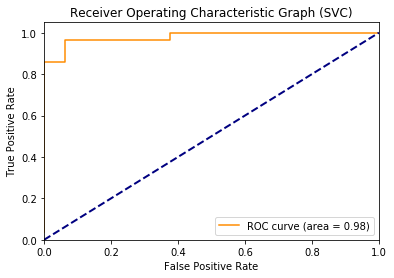

In [36]:
print("test_corpus_target:", np.array(test_corpus_target))
print("probas: ", probas_[:, 1])

for i in range(len(probas_)):
    print("target:", test_corpus_target[i])
    print("proba: ", probas_[i,1])
    print("difference", abs(test_corpus_target[i]-probas_[i,1]))
    print("===========")

fpr, tpr, _ = roc_curve(test_corpus_target, probas_[:, 1], pos_label=1, drop_intermediate=False)
print("thresholds: ", _)
roc_auc = auc(fpr, tpr)

print("fpr", fpr)
print("tpr", tpr)
print("roc", roc_auc)

for i in range(len(fpr)):
    print(i)
    print("fpr", fpr[i])
    print("tpr", tpr[i])
    print("threshold", _[i])
    print("\n")

# printing ROC
plt.figure()
lwr = 2
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lwr, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Graph (SVC)')
plt.legend(loc="lower right")
plt.show()

# PRECISION_RECALL Curve

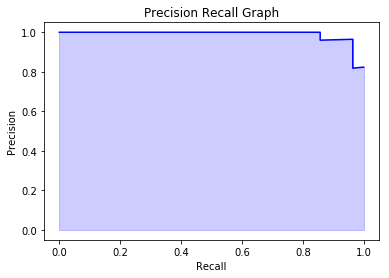

In [42]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(test_corpus_target, probas_[:, 1])
plt.plot(recall, precision, color="blue")
plt.title("Precision Recall Graph")
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
plt.xlabel("Recall")
plt.ylabel("Precision")


plt.show()
